## Bayes by Backprop



Status of the notebook :
 - A working implementation of a Bayesian NN from Scratch inkl. Training by Bayes by Backprop [Blu15]
 

#### Motivation for uncertainty in the weights

According to [Blu15]
- Regularization via compression cost on the weights
- Richer representation and predictions from cheap model averaging 
- Exploration in simple reinforcement learning

from [XX]
- Pruning of neural networks for reduced storage and computational cost, e.g. for mobile devices.

#### Bayesian Neural Networks

- instead of point estimates (MAP) we describe the weights
by a probability distributions $p(\theta)$ (see Figure 1 of [Blu15]).
- e.g. mean field approximation
 - $p({\bf w}) = \prod_i p(w_i)$
 - with Gaussians $p(w_i) = \mathcal N(\mu_i, \sigma_i^2)$



#### Baysian Inference

- Posterior: $p({\bf w}\mid \mathcal D)$
- Prediction: $p({\bf \hat y} \mid {\bf \hat x}) = \mathbb E_{p({\bf w}\mid \mathcal D)}\left[p({\bf \hat y} \mid {\bf \hat x}, {\bf w})\right]$
 - equivalent of using an ensemble of an uncountable infinite number of neural networks 
 - intractable for larger NNs

#### Variational Approximation

$$
q({\bf w}\mid \theta)
$$

Minimization of the ELBO:

$$
\begin{align}
\theta^* &= \text{arg} \min_\theta \mathcal D_{KL} \left[ q({\bf w}\mid \theta) \mid \mid p({\bf w}\mid \mathcal D)\right] \\
&= \text{arg} \min_\theta \mathcal D_{KL} \left[ q({\bf w}\mid \theta) \mid \mid p({\bf w}) p(\mathcal D \mid \mathcal {\bf w})\right] \\
&= \text{arg} \min_\theta \left( \mathcal D_{KL} \left[ q({\bf w}\mid \theta) \mid \mid p({\bf w}) \right] 
- \mathbb E_{q({\bf w}\mid \theta)}\left[\log p(\mathcal D \mid {\bf w})\right]\right)\\
\end{align}
$$



- prior dependent part / complexity cost:
$\mathcal D_{KL} \left[ q({\bf w}\mid \theta) \mid \mid p({\bf w}) \right]$


- data dependent part / likelihood cost: 
$-\mathbb E_{q({\bf w}\mid \theta)}\left[\log p(\mathcal D \mid {\bf w})\right]$

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline


# we use the lightweight deep learning library dp
# you have to put dp.py in the same folder as this noebook
# you can download it from
# https://gitlab.com/deep.TEACHING/educational-materials/-/blob/master/notebooks/differentiable-programming/dp.py
# if you have downloaded the complete deep teaching git repo you find it in the folder ../differentiable-programming/

import dp # differentiable programming module
from dp import Node

In [2]:
# get the csv data from
#   https://pjreddie.com/projects/mnist-in-csv/
#data_path = "/Users/chris/data/mnist_csv/"
data_path = "/home/chris/Downloads/" 

try:
    train_data_mnist
except NameError:
    train_data_mnist = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")
    test_data_mnist  = np.loadtxt(data_path + "mnist_test.csv", delimiter=",")

# TODO use standard MNIST data for faster loading

In [3]:
original_dim = 784 # Number of pixels in MNIST images.
output_dim = nb_classes = 10 # dimensionality of the latent code z.
intermediate_dim = 128 # Size of the hidden layer.
epochs = 30
image_dim = int(np.sqrt(original_dim))
image_dim

28

In [4]:
def get_xy_mnist(data_mnist=train_data_mnist):
    x = data_mnist[:,1:]
    x = x / 255. 
    y = data_mnist[:,0]
    return x, y

In [5]:
x_train, y_train_ = get_xy_mnist()
x_test, y_test_ = get_xy_mnist(test_data_mnist)

In [6]:
# one hot encoding for y
def one_hot_encoding(y, nb_classes=nb_classes):
    m = y.shape[0]
    y_ = np.zeros((m, nb_classes), dtype=int)
    y_[np.arange(m), y.astype(int)] = 1
    return y_
y_train = one_hot_encoding(y_train_)
y_test = one_hot_encoding(y_test_)

In [7]:
# Standard NN
class FeedForwardNN(dp.Model):
    
    def __init__(self, original_dim=original_dim, 
                 intermediate_dim=intermediate_dim, 
                 output_dim=output_dim):
        super(FeedForwardNN, self).__init__()
        
        # param
        self.fc1 = self.ReLu_Layer(original_dim, intermediate_dim, "fc1")
        self.fc2 = self.Linear_Layer(intermediate_dim, output_dim, "fc2")
        
    def forward(self, x):
        assert isinstance(x, Node)
        h1 = self.fc1(x)
        return self.fc2(h1).softmax()
             
    def loss(self, x, y=None):
        n = x.shape[0]
        y_pred = self.forward(x)
        loss = - y * y_pred.log()
        return loss.sum()/n
        

In [8]:
batch_size=64
def random_batch(x_train=x_train, y_train=y_train, batch_size=batch_size):
    n = x_train.shape[0]
    indices = np.random.randint(0,n, size=batch_size)
    return x_train[indices], y_train[indices]

In [9]:
model = FeedForwardNN()

In [10]:
x_, y_ = random_batch()
y_pred = model.forward(x=Node(x_))

In [11]:
loss = model.loss(x=Node(x_), y=Node(y_))

In [12]:
optimizer = dp.optimizer.RMS_Prop(model, x_train, y_train, {"alpha":0.001, "beta2":0.9}, batch_size=batch_size)
optimizer.train(steps=3000, print_each=100)

iteration	loss
1 	 2.44259090021864
100 	 0.3563105105925153
200 	 0.13585114737789328
300 	 0.3465467162522951
400 	 0.12276877525842722
500 	 0.24951843636899185
600 	 0.09596878225649089
700 	 0.23344820516729475
800 	 0.27883557784488594
900 	 0.1192808788147787
1000 	 0.10031648282381328
1100 	 0.09347440575806035
1200 	 0.11510715133199337
1300 	 0.06816317026451826
1400 	 0.142378640435843
1500 	 0.11166325522516689
1600 	 0.023504936999704743
1700 	 0.14019522352918665
1800 	 0.05362989091061093
1900 	 0.1336230729464381
2000 	 0.031242733851440187
2100 	 0.03128991045292066
2200 	 0.0401203391344262
2300 	 0.05551679313985189
2400 	 0.12693988665392572
2500 	 0.11841020484944927
2600 	 0.04701073373726761
2700 	 0.052503179447690604
2800 	 0.06533828229224387
2900 	 0.09233361711525746
3000 	 0.006093851614539158


array([[0.00609385]])

In [13]:
# accuracy on train set
y_pred = model.forward(Node(x_train)).value.argmax(axis=1)
print ((y_pred==y_train_).sum()/y_train.shape[0]) 

0.9783


In [14]:
# accuracy on test set
y_pred = model.forward(Node(x_test)).value.argmax(axis=1)
print ((y_pred==y_test_).sum()/y_test.shape[0]) 

0.9702


#### Bayesian Neural Network

In [24]:
init_rho = -4.

# TODO: global variable
sample_store = dict()

softplus = lambda x: (1. + x.exp()).log()
NeuralNode = dp.NeuralNode


def _Linear_Bayes_Layer(fan_in, fan_out, name=None, param=dict(), initializer=None):
   
    assert isinstance(name, str)    
    assert initializer is None # not implemented
    
    mu_weight_name, mu_weight_value = NeuralNode.get_name_and_set_param(param, name, "mu_weight")
    rho_weight_name, rho_weight_value = NeuralNode.get_name_and_set_param(param, name, "rho_weight")
    mu_bias_name, mu_bias_value = NeuralNode.get_name_and_set_param(param, name, "mu_bias")
    rho_bias_name, rho_bias_value = NeuralNode.get_name_and_set_param(param, name, "rho_bias")
    
    if mu_weight_value is None:
        mu_weight_value = NeuralNode._initialize_W(fan_in, fan_out)
        mu_bias_value = NeuralNode._initialize_b(fan_in, fan_out)
        param[mu_weight_name] = mu_weight_value
        param[mu_bias_name] = mu_bias_value
  
        rho_weight_value = np.ones_like(mu_weight_value) * init_rho
        rho_bias_value = np.ones_like(mu_bias_value) * init_rho
        param[rho_weight_name] = rho_weight_value
        param[rho_bias_name] = rho_bias_value

    nodes = dict()  # type: Dict[str, Node]
    def set_node(nodes, value, name):
        node = Node(value, name)
        nodes[name] = node
        return node
    W_mu = set_node(nodes, mu_weight_value, mu_weight_name)
    b_mu = set_node(nodes, mu_bias_value, mu_bias_name)    
    W_rho = set_node(nodes, rho_weight_value, rho_weight_name)
    b_rho = set_node(nodes, rho_bias_value, rho_bias_name) 
    
    def _layer(X):
        epsilon_w = np.random.normal(size=(fan_in, fan_out))
        epsilon_b = np.random.normal(size=(1, fan_out))
        W_ = W_mu + Node(epsilon_w) * softplus(W_rho)
        b_ = b_mu + Node(epsilon_b) * softplus(b_rho)
        
        # we need the samples for our loss
        weight_sample_name = NeuralNode._get_fullname(name, "weight_sample")
        bias_sample_name = NeuralNode._get_fullname(name, "bias_sample")
        sample_store[weight_sample_name] = W_
        sample_store[bias_sample_name] = b_
        return X.dot(W_) + b_

    return _layer, param, nodes


def Linear_Bayes_Layer(self, fan_in, fan_out, name=None):
    return self._set_layer(fan_in, fan_out, name, _Linear_Bayes_Layer)

setattr(dp.Model, "Linear_Bayes_Layer", Linear_Bayes_Layer)

In [26]:
class BayesFeedForwardNN(dp.Model):
    
    def __init__(self, original_dim=original_dim, 
                 intermediate_dim=intermediate_dim, 
                 output_dim=output_dim):
        super(BayesFeedForwardNN, self).__init__()
        
        # param
        self.fc1 = self.Linear_Bayes_Layer(original_dim, intermediate_dim, "fc1")
        self.fc2 = self.Linear_Bayes_Layer(intermediate_dim, output_dim, "fc2")
        
    def forward(self, x):
        assert isinstance(x, Node)
        h1 = self.fc1(x).relu()
        return self.fc2(h1).softmax()
             
    def loss(self, x, y=None):
        raise NotImplementedError()
    
    

$$
\begin{align}
\theta^* &= \text{arg} \min_\theta \left( \mathcal D_{KL} \left[ q({\bf w}\mid \theta) \mid \mid p({\bf w}) \right] 
- \mathbb E_{q({\bf w}\mid \theta)}\left[\log p(\mathcal D \mid {\bf w})\right]\right)\\
&= \text{arg} \min_\theta \left( \mathbb E_{q({\bf w}\mid \theta)}\left[ \log q({\bf w}\mid \theta)\right]-
\mathbb E_{q({\bf w}\mid \theta)}\left[\log p({\bf w})\right]
- \mathbb E_{q({\bf w}\mid \theta)}\left[\log p(\mathcal D \mid {\bf w})\right]\right)\\
\end{align}
$$

So equivalently we want to minimize the following loss:


$$
loss = \mathbb E_{q({\bf w}\mid \theta)}\left[\log q({\bf w}\mid \theta)\right]-
\mathbb E_{q({\bf w}\mid \theta)}\left[ \log p({\bf w})\right]
- \mathbb E_{q({\bf w}\mid \theta)}\left[\log p(\mathcal D \mid {\bf w})\right]
$$


#### Entropy
$$
\mathbb E_{q({\bf w}\mid \theta)}\left[ \log  q({\bf w}\mid \theta)\right]
$$

Note: That's the negative entropy of $q({\bf w}\mid \theta)$. So this terms tries to
maximize the entropy of $q$.

We can compute the expectations by Monte-Carlo estimates.

So we sample for each data point $l$ of a mini-batch a sample from the variational distribution: 

$${\bf w}^{(l)} \sim q({\bf w}\mid \theta) $$

- $l \in [1, 2, \dots, m]$
- $m$ number of data points in the mini-batch
- $n$ total number of data points 

Then we have for the approximated loss in the mini-batch:
$$
loss_{mb}  \approx  \frac{m}{n}\sum_{l=1}^m  \log q({\bf w}^{(l)}\mid \theta)- \frac{m}{n}\sum_{l=1}^m \log p({\bf w}^{(l)}) - \sum_{l=1}^m\log p({\bf y}^{(l)} \mid {\bf w}^{(l)}, {\bf x}^{(l)})
$$

#### negative Log-Likelihood

$$
- \sum_{l=1}^m\log p({\bf y}^{(l)} \mid {\bf w}^{(l)}, {\bf x}^{(l)})
$$

#### Log-Posterior

$$
\frac{m}{n} \sum_{l=1}^m  \log q({\bf w}^{(l)}\mid \theta)
$$



In [27]:
PI_2 = 2.0 * np.pi
LOG_PI_2 = float(np.log(PI_2))

def log_normal(sample, mu, sigma):
    return - 0.5 * LOG_PI_2 - sigma.log() - (sample-mu).square() / (2.*sigma.square())

#### Log-Prior

$$
- \frac{m}{n} \sum_{l=1}^n \log p({\bf w}^{(l)}) 
$$

Mean-Field approximation:
$$
\log p({\bf w}^{(l)})  = \sum_i\log p(w_i^{(l)})
$$

with Gaussian-Priors:

$$
p(weight_i) = \mathcal N(weight_i \mid 0,\sigma_{weight}^2)
$$

$$
p(bias_j) = \mathcal N(bias_j \mid 0,\sigma_{bias}^2)
$$


In [28]:
# scale mixture prior
def normal(w, var, mu=0):
    s = 1.0 / np.sqrt(PI_2 * var)
    g = (- (w - mu).square() / (2 * float(var))).exp()
    return s * g

var_g1 = np.exp(-1.)**2
var_g2 = np.exp(-7.)**2
p = 0.25
def log_scale_mixture_prior(w, var_g1=var_g1, var_g2=var_g2):
    first = p * normal(w, var_g1)
    second = (1 - p) * normal(w, var_g2)
    return (first + second).log()

In [29]:
# Hyperparameter
sigma = Node(0.5)

M = x_train.shape[0]/batch_size# num. of batches
def loss(self, x, y):# TODO: nb_batched should be given as argument
    m = x.shape[0]
    y_pred = self.forward(x)
    
    # y must be one hot encoded
    assert (y.shape == y_pred.shape)
    
    # data likelihood - here cross-entropy
    neg_log_likelihood = - (y * y_pred.log()).sum()
        
    # prior
    log_prior = 0
    for sample_name, sample_value in sample_store.items():
        if sample_name.endswith("_sample"):
                #log_prior += log_normal(sample_value, 0., sigma).sum()
                log_prior += log_scale_mixture_prior(sample_value).sum()
      
    #variational posterior
    log_posterior = 0.
    for nnode_name, nnode_value in self.neural_nodes.items():
        nn = nnode_name.split("_")
        sample_weight = sample_store[nn[0]+"_weight_sample"]
        sample_bias = sample_store[nn[0]+"_bias_sample"]
        for node_name, node_value in nnode_value.nodes.items():
            if node_name.endswith("mu_weight"):
                mu_weight = node_value
            if node_name.endswith("mu_bias"):
                mu_bias = node_value
            if node_name.endswith("rho_weight"):
                rho_weight = node_value
            if node_name.endswith("rho_bias"):
                rho_bias = node_value
        log_posterior += log_normal(sample_weight, mu_weight, softplus(rho_weight)).sum()
        log_posterior += log_normal(sample_bias, mu_bias, softplus(rho_bias)).sum()
        
    # TODO different weighting of complexity vd data cost during training
    # see paper 3.4.
    loss_ = neg_log_likelihood + 1/M*(log_posterior - log_prior)
    return loss_

BayesFeedForwardNN.loss = loss

In [30]:
bayes_model = BayesFeedForwardNN()

In [31]:
optimizer = dp.optimizer.RMS_Prop(bayes_model, x_train, y_train, 
                                  {"alpha":0.001, "beta2":0.9}, 
                                  batch_size=batch_size)
optimizer.train(steps=10000, print_each=100)

iteration	loss
1 	 555.8524743339495
100 	 432.19328154564505
200 	 425.5282834927088
300 	 399.7855085185947
400 	 388.1594144420811
500 	 381.9412499799676
600 	 385.74467175502974
700 	 386.5106035931867
800 	 375.8686212840836
900 	 382.0504437684173
1000 	 376.279215690231
1100 	 365.2414078904296
1200 	 368.46763266460977
1300 	 373.29237033984776
1400 	 366.15632683246065
1500 	 359.5466638302649
1600 	 359.9014343186206
1700 	 355.3065088551375
1800 	 350.5585995305178
1900 	 350.9459805287687
2000 	 343.48580990549965
2100 	 346.8447042158543
2200 	 341.12262461199634
2300 	 346.77652392774763
2400 	 336.1143906573853
2500 	 341.75459864389205
2600 	 344.6684848241343
2700 	 338.0187913673604
2800 	 330.91542750706253
2900 	 330.79186976649885
3000 	 336.3696240521043
3100 	 323.4057671181288
3200 	 337.49009462579403
3300 	 324.85056015522173
3400 	 324.4397445491907
3500 	 319.50658121097536
3600 	 325.44405122044145
3700 	 312.13655154264427
3800 	 311.7469325216087
3900 	 

array([[209.60373751]])

In [32]:
y_pred = bayes_model.forward(Node(x_test)).value
y_pred = y_pred.argmax(axis=1)
(y_pred == y_test_).sum()/y_test_.shape[0]

0.9662

The expectation can be approximated by
$$p({\bf \hat y} \mid {\bf \hat x}) \approx \mathbb E_{q({\bf w}\mid \mathcal D)}\left[p({\bf \hat y} \mid {\bf \hat x}, {\bf w})\right]$$

MC-Estimate:

$$p({\bf \hat y} \mid {\bf \hat x}) \approx \mathbb \sum_{{\bf w}'}p({\bf \hat y} \mid {\bf \hat x}, {\bf w'})$$

In [33]:
y_preds = []
for i in range(10):
    y_preds.append(bayes_model.forward(Node(x_test)).value)
y_preds = np.array(y_preds)

In [34]:
y_pred = y_preds.mean(axis=0)
y_pred = y_pred.argmax(axis=1)
(y_pred == y_test_).sum()/y_test_.shape[0]

0.9746

In [35]:
# uncertainty of the max_pred
y_uncertainty = y_preds.std(axis=0)

In [36]:
# the most uncertained 
i=y_uncertainty[range(len(y_uncertainty)),y_pred].argmax()
plt.figure()
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()
print(y_preds.mean(axis=0)[i].max())

0.5789877528566475


In [37]:
i = y_preds.mean(axis=0)[range(len(y_pred)), y_pred].argmin()
print(y_pred[i])

5


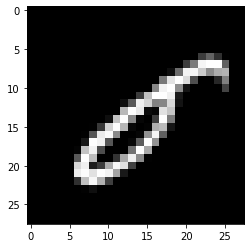

0.23103863529292376


In [38]:
# the lowest class prediction max
plt.figure()
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()
print(y_preds.mean(axis=0)[i].max())

#### Literature

- [Blu15] Charles Blundell, Julien Cornebise, Koray Kavukcuoglu, Daan Wierstra: Weight Uncertainty in Neural Networks, https://arxiv.org/abs/1505.05424